In [ ]:
import pandas as pd
import datetime
import numpy as np
import warnings
import statsmodels.api as sm
import matplotlib.pylab as plt
from matplotlib.pylab import style
from matplotlib.font_manager import FontProperties
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta

In [ ]:
!pip install yfinance

In [ ]:
start = (datetime.today() - timedelta(days=15)).date()
end = (datetime.today()).date()

In [ ]:
from pandas_datareader import data as pdr

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
dfN = pdr.get_data_yahoo("NVDA",interval= '30m',start=start, end=end)
dfA = pdr.get_data_yahoo("AAPL",interval= '30m',start=start, end=end)
dfT = pdr.get_data_yahoo("TSLA",interval= '30m',start=start, end=end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
df = pd.concat([dfN['Close'], dfA['Close'], dfT['Close']], axis=1, join='inner')

In [ ]:
df.columns = ['N_Close', 'A_Close', 'T_Close']

In [ ]:
df.tail()

,N_Close,A_Close,T_Close
Datetime,,,
2023-11-10 13:30:00,481.650085,185.740097,214.660095
2023-11-10 14:00:00,482.834991,185.850006,214.809998
2023-11-10 14:30:00,483.509888,185.580093,214.945007
2023-11-10 15:00:00,483.214996,186.119995,214.869705
2023-11-10 15:30:00,483.399994,186.339996,214.690002


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 143 entries, 2023-10-27 09:30:00 to 2023-11-10 15:30:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   N_Close  143 non-null    float64
 1   A_Close  143 non-null    float64
 2   T_Close  143 non-null    float64
dtypes: float64(3)
memory usage: 8.5 KB


Considering the significant differences in the prices of the three stocks, it can be challenging to visualize them together. Therefore, we should take the natural logarithm (log) of the prices.

In [ ]:
df['N_log'] = np.log(df['N_Close'])
df['A_log'] = np.log(df['A_Close'])
df['T_log'] = np.log(df['T_Close'])

In [ ]:
df.head()

,N_Close,A_Close,T_Close,N_log,A_log,T_log
Datetime,,,,,,
2023-10-27 09:30:00,407.880005,167.889999,208.929993,6.010973,5.123309,5.341999
2023-10-27 10:00:00,407.160004,168.160004,208.500000,6.009206,5.124916,5.339939
2023-10-27 10:30:00,405.690002,168.434998,208.177002,6.005589,5.126550,5.338389
2023-10-27 11:00:00,409.575012,168.735001,210.070007,6.015120,5.128329,5.347441
2023-10-27 11:30:00,408.869995,168.369995,210.610001,6.013397,5.126164,5.350008


In [ ]:
#train test split
train_data = df[['N_log','A_log','T_log']].iloc[:-15]
test_data = df[['N_log','A_log','T_log']].iloc[-15:]

In [ ]:
test_data

,N_log,A_log,T_log
Datetime,,,
2023-11-09 15:00:00,6.152456,5.203237,5.338163
2023-11-09 15:30:00,6.151785,5.206421,5.346822
2023-11-10 09:30:00,6.169277,5.215914,5.357859
2023-11-10 10:00:00,6.163231,5.213739,5.333201
2023-11-10 10:30:00,6.170489,5.216239,5.342621
2023-11-10 11:00:00,6.169579,5.219004,5.349153
2023-11-10 11:30:00,6.170217,5.218895,5.357741
2023-11-10 12:00:00,6.172556,5.220031,5.359648
2023-11-10 12:30:00,6.176617,5.221888,5.360024


In [ ]:
def plot_func(x,y,z):

    x.plot()
    y.plot()
    z.plot()
    plt.legend()
    plt.show()

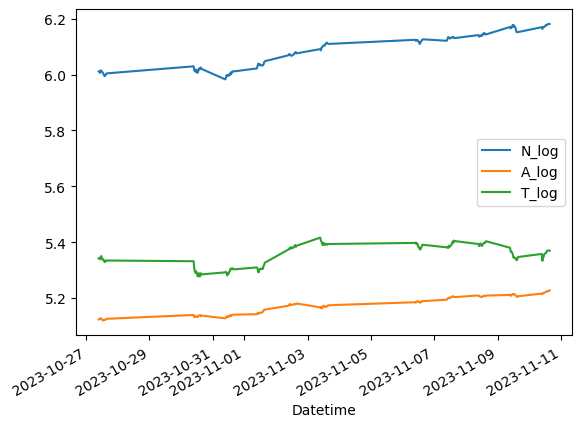

In [ ]:
Nlg = df['N_log']
Alg = df['A_log']
Tlg = df['T_log']
plot_func(Nlg, Alg , Tlg)

<Axes: ylabel='Density'>

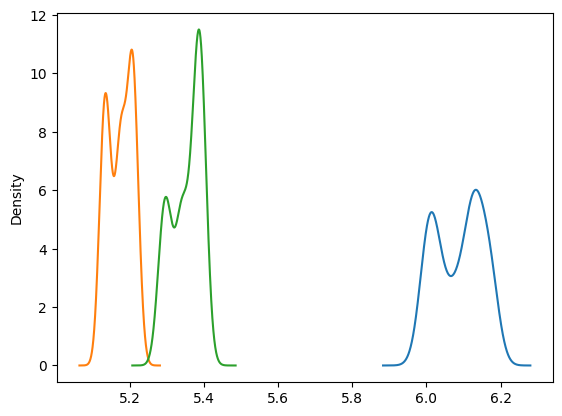

In [ ]:
#Distribution of the dataset
Nlg.plot(kind='kde')
Alg.plot(kind='kde')
Tlg.plot(kind='kde')

**Model**

The model I choose to use is VARMAX model. It is the go-to model for multivariate time series. It adds a moving average component to the VAR model, and it can allow for external, or exogenous, variables as well. The components in the VARMAX model are therefore

V for vector indicating that it’s a multivariate model

AR for autoregression

MA for moving average

X for the use of exogenous variables (in addition to the endogenous variables)


One of the most important things is that **the** time series in a VARMAX have to be **STATIONARY**. So I use ADF test in the first place.

ADF (Augmented Dickey-Fuller) Test

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

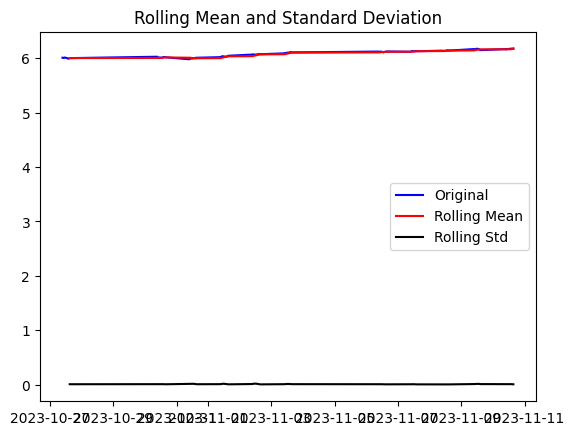

Results of dickey fuller test
Test Statistics                 -0.372524
p-value                          0.914586
No. of lags used                 0.000000
Number of observations used    142.000000
critical value (1%)             -3.477262
critical value (5%)             -2.882118
critical value (10%)            -2.577743
dtype: float64


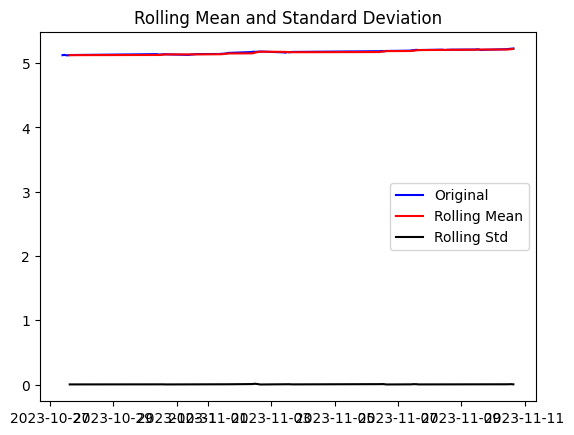

Results of dickey fuller test
Test Statistics                 -0.501515
p-value                          0.891721
No. of lags used                 0.000000
Number of observations used    142.000000
critical value (1%)             -3.477262
critical value (5%)             -2.882118
critical value (10%)            -2.577743
dtype: float64


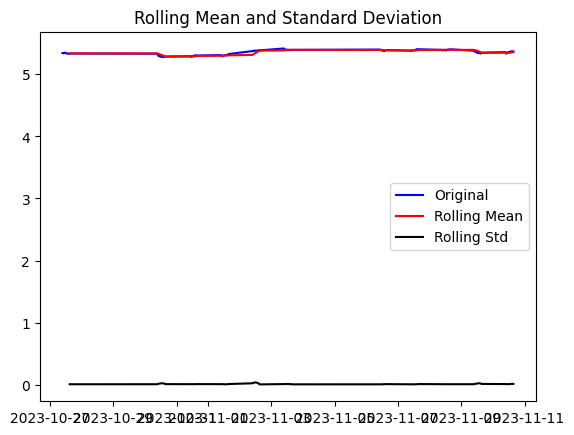

Results of dickey fuller test
Test Statistics                 -1.877257
p-value                          0.342834
No. of lags used                13.000000
Number of observations used    129.000000
critical value (1%)             -3.482088
critical value (5%)             -2.884219
critical value (10%)            -2.578864
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
for i in [Nlg, Alg, Tlg] :
    test_stationarity(i)

We can’t rule out the Null hypothesis because the p-values of all three stocks are much higher than 0.05. And all the test values is bigger than critical values(1%, 5%, 10%).

So the next step is to see how the data performs after being differenced i-th time.

In [ ]:
for i in range(1,4):
    score1 = adfuller(Nlg.diff(i).dropna())[1]
    score2 = adfuller(Alg.diff(i).dropna())[1]
    score3 = adfuller(Tlg.diff(i).dropna())[1]
    print('-' * 70)
    print("The p-value for differencing the data for the ",i, "th time",'/n')
    print()
    print(score1, score2, score3)

----------------------------------------------------------------------
The p-value for differencing the data for the  1 th time /n

3.740484050003145e-25 9.511761515815374e-25 0.19598541435508465
----------------------------------------------------------------------
The p-value for differencing the data for the  2 th time /n

2.6445173118123276e-09 0.0006764249896465496 0.04418412424939256
----------------------------------------------------------------------
The p-value for differencing the data for the  3 th time /n

0.003988106517971928 0.00011252449339869942 0.021251172246417403


Result: The data exhibited optimal performance after a single differencing and can now be considered stationary.

In [ ]:
df_diff=train_data.diff(1).dropna()
print(df_diff)

                        N_log     A_log     T_log
Datetime                                         
2023-10-27 10:00:00 -0.001767  0.001607 -0.002060
2023-10-27 10:30:00 -0.003617  0.001634 -0.001550
2023-10-27 11:00:00  0.009531  0.001780  0.009052
2023-10-27 11:30:00 -0.001723 -0.002166  0.002567
2023-10-27 12:00:00 -0.002915 -0.003630 -0.008631
...                       ...       ...       ...
2023-11-09 12:30:00  0.004732  0.001959  0.000590
2023-11-09 13:00:00 -0.003437 -0.001251 -0.003127
2023-11-09 13:30:00 -0.004085 -0.003169 -0.001364
2023-11-09 14:00:00 -0.008027 -0.001633  0.000862
2023-11-09 14:30:00 -0.008974 -0.002437 -0.007396

[127 rows x 3 columns]


In [ ]:
#Using differenced train dataset to train the VARMAX model
warnings.filterwarnings('ignore')
model_1 = sm.tsa.VARMAX(df_diff, order=(4,4))
res_1 = model_1.fit(maxiter=1000)

# predicting differenced  test dataset
pre_1=res_1.forecast(15)
print("Using Time Series Algorithms to Forecast Differential Values:")
print(pre_1)

Using Time Series Algorithms to Forecast Differential Values:
        N_log     A_log     T_log
127  0.002141  0.000726 -0.000114
128  0.002378  0.000065 -0.001362
129  0.002293  0.001374 -0.001063
130  0.000268  0.000398  0.000035
131  0.001167  0.000669  0.000066
132  0.000880  0.000631 -0.000255
133  0.001121  0.000563 -0.000176
134  0.001081  0.000640 -0.000074
135  0.001174  0.000682 -0.000057
136  0.001089  0.000630 -0.000105
137  0.001115  0.000648 -0.000102
138  0.001108  0.000646 -0.000071
139  0.001125  0.000648 -0.000077
140  0.001113  0.000648 -0.000086
141  0.001116  0.000646 -0.000081


In [ ]:
#Create a matrix to store the de-differenced predicted values
pre = pd.DataFrame(np.zeros((16,3)),columns=['N_log','A_log','T_log'])
pre.index = train_data.index[-1:].append(test_data.index)
pre.iloc[0,:]=train_data.iloc[-1,0:3]

In [ ]:
pre

,N_log,A_log,T_log
Datetime,,,
2023-11-09 14:30:00,6.151178,5.206065,5.334939
2023-11-09 15:00:00,0.000000,0.000000,0.000000
2023-11-09 15:30:00,0.000000,0.000000,0.000000
2023-11-10 09:30:00,0.000000,0.000000,0.000000
2023-11-10 10:00:00,0.000000,0.000000,0.000000
2023-11-10 10:30:00,0.000000,0.000000,0.000000
2023-11-10 11:00:00,0.000000,0.000000,0.000000
2023-11-10 11:30:00,0.000000,0.000000,0.000000
2023-11-10 12:00:00,0.000000,0.000000,0.000000


In [ ]:
#The process of de-differencing
for i in range(len(pre_1)):
    pre.iloc[i + 1][0] = pre.iloc[i][0] + pre_1.iloc[i][0]
    pre.iloc[i + 1][1] = pre.iloc[i][1] + pre_1.iloc[i][1]
    pre.iloc[i + 1][2] = pre.iloc[i][2] + pre_1.iloc[i][2]
pre = pre.iloc[1:]
print("The predicted data after de-differencing：")
print(pre)


The predicted data after de-differencing：
                        N_log     A_log     T_log
Datetime                                         
2023-11-09 15:00:00  6.153320  5.206791  5.334825
2023-11-09 15:30:00  6.155698  5.206856  5.333463
2023-11-10 09:30:00  6.157992  5.208230  5.332400
2023-11-10 10:00:00  6.158259  5.208628  5.332434
2023-11-10 10:30:00  6.159427  5.209297  5.332500
2023-11-10 11:00:00  6.160307  5.209928  5.332244
2023-11-10 11:30:00  6.161428  5.210491  5.332069
2023-11-10 12:00:00  6.162508  5.211131  5.331995
2023-11-10 12:30:00  6.163682  5.211812  5.331938
2023-11-10 13:00:00  6.164771  5.212442  5.331833
2023-11-10 13:30:00  6.165886  5.213090  5.331731
2023-11-10 14:00:00  6.166994  5.213736  5.331660
2023-11-10 14:30:00  6.168119  5.214384  5.331583
2023-11-10 15:00:00  6.169233  5.215032  5.331497
2023-11-10 15:30:00  6.170348  5.215678  5.331417


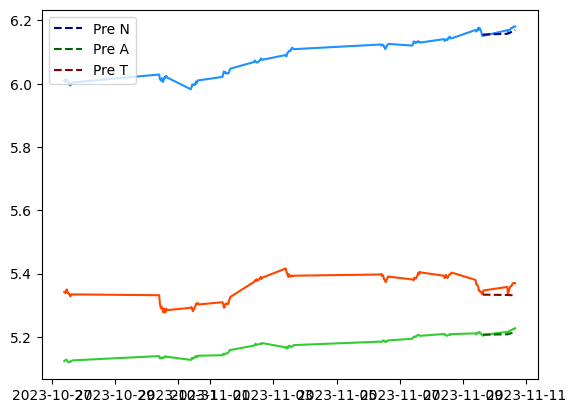

In [ ]:
#plt.plot(df['N_log'],'dodgerblue',df['A_log'],'limegreen',df['T_log'],'orangered')
#plt.plot(pre['N_log'],'darkblue',pre['A_log'],'darkgreen',pre['T_log'],'darkred')
#plt.show()

plt.plot(df['N_log'], 'dodgerblue')
plt.plot(df['A_log'], 'limegreen')
plt.plot(df['T_log'], 'orangered')

plt.plot(pre['N_log'], 'darkblue', label='Pre N', linestyle='--')
plt.plot(pre['A_log'], 'darkgreen', label='Pre A', linestyle='--')
plt.plot(pre['T_log'], 'darkred', label='Pre T', linestyle='--')

plt.legend(loc='upper left')
plt.show()


In [ ]:
#Evaluation

error_1=pow(test_data['N_log']-pre['N_log'],2)
MSE1=error_1.sum()/len(test_data)
error_2=pow(test_data['A_log']-pre['A_log'],2)
MSE2=error_2.sum()/len(test_data)
error_3=pow(test_data['T_log']-pre['T_log'],2)
MSE3=error_3.sum()/len(test_data)
print(MSE1,MSE2,MSE3)

0.00010298037734198271 7.917272167338271e-05 0.0007755756040893107


I think it's really good.

In [ ]:
pre['N_Close'] = np.exp(pre['N_log'])
pre['A_Close'] = np.exp(pre['A_log'])
pre['T_Close'] = np.exp(pre['T_log'])
pre

,N_log,A_log,T_log,N_Close,A_Close,T_Close
Datetime,,,,,,
2023-11-09 15:00:00,6.153320,5.206791,5.334825,470.275942,182.507483,207.436457
2023-11-09 15:30:00,6.155698,5.206856,5.333463,471.395807,182.519257,207.154121
2023-11-10 09:30:00,6.157992,5.208230,5.332400,472.478167,182.770258,206.933957
2023-11-10 10:00:00,6.158259,5.208628,5.332434,472.604740,182.842966,206.941131
2023-11-10 10:30:00,6.159427,5.209297,5.332500,473.156663,182.965420,206.954689
2023-11-10 11:00:00,6.160307,5.209928,5.332244,473.573368,183.080851,206.901825
2023-11-10 11:30:00,6.161428,5.210491,5.332069,474.104387,183.183893,206.865485
2023-11-10 12:00:00,6.162508,5.211131,5.331995,474.616946,183.301225,206.850227
2023-11-10 12:30:00,6.163682,5.211812,5.331938,475.174310,183.426190,206.838450


# Now let's make stock price predictions for November 13th using the entire dataset.

In [ ]:
dfw = df[['N_log','A_log','T_log']]

In [ ]:
dfw.tail()

,N_log,A_log,T_log
Datetime,,,
2023-11-10 13:30:00,6.177218,5.224348,5.369056
2023-11-10 14:00:00,6.179675,5.224940,5.369754
2023-11-10 14:30:00,6.181072,5.223487,5.370382
2023-11-10 15:00:00,6.180462,5.226392,5.370032
2023-11-10 15:30:00,6.180844,5.227573,5.369195


In [ ]:
dfw_diff=dfw.diff(1).dropna()
print(dfw_diff)

                        N_log     A_log     T_log
Datetime                                         
2023-10-27 10:00:00 -0.001767  0.001607 -0.002060
2023-10-27 10:30:00 -0.003617  0.001634 -0.001550
2023-10-27 11:00:00  0.009531  0.001780  0.009052
2023-10-27 11:30:00 -0.001723 -0.002166  0.002567
2023-10-27 12:00:00 -0.002915 -0.003630 -0.008631
...                       ...       ...       ...
2023-11-10 13:30:00  0.001070  0.001806  0.006684
2023-11-10 14:00:00  0.002457  0.000592  0.000698
2023-11-10 14:30:00  0.001397 -0.001453  0.000628
2023-11-10 15:00:00 -0.000610  0.002905 -0.000350
2023-11-10 15:30:00  0.000383  0.001181 -0.000837

[142 rows x 3 columns]


In [ ]:
#Using differenced train dataset to train the VARMAX model
warnings.filterwarnings('ignore')
model_2 = sm.tsa.VARMAX(dfw_diff, order=(4,4))
res_2 = model_2.fit(maxiter=1000)

# predicting differenced  10 values
pre_13=res_2.forecast(10)
print("Using Time Series Algorithms to Forecast Differential Values:")
print(pre_13)

Using Time Series Algorithms to Forecast Differential Values:
        N_log     A_log     T_log
142  0.001057  0.000086 -0.000627
143  0.001622  0.001224  0.000397
144  0.001092  0.000782  0.000902
145  0.001150  0.000679  0.000218
146  0.001089  0.000754  0.000119
147  0.001207  0.000694  0.000309
148  0.001260  0.000769  0.000264
149  0.001215  0.000756  0.000190
150  0.001178  0.000719  0.000175
151  0.001198  0.000741  0.000206


In [ ]:
date_index = pd.date_range(start='2023-11-13 09:00:00', periods=10, freq='30T')

In [ ]:
date_index

DatetimeIndex(['2023-11-13 09:00:00', '2023-11-13 09:30:00',
               '2023-11-13 10:00:00', '2023-11-13 10:30:00',
               '2023-11-13 11:00:00', '2023-11-13 11:30:00',
               '2023-11-13 12:00:00', '2023-11-13 12:30:00',
               '2023-11-13 13:00:00', '2023-11-13 13:30:00'],
              dtype='datetime64[ns]', freq='30T')

In [ ]:
#Create a matrix to store the de-differenced predicted values
pred = pd.DataFrame(np.zeros((11,3)),columns=['N_log','A_log','T_log'])
pred.index = pd.Index.union(train_data.index[-1:], date_index)
pred.iloc[0,:]=dfw.iloc[-1,0:3]
pred

,N_log,A_log,T_log
2023-11-09 14:30:00,6.180844,5.227573,5.369195
2023-11-13 09:00:00,0.000000,0.000000,0.000000
2023-11-13 09:30:00,0.000000,0.000000,0.000000
2023-11-13 10:00:00,0.000000,0.000000,0.000000
2023-11-13 10:30:00,0.000000,0.000000,0.000000
2023-11-13 11:00:00,0.000000,0.000000,0.000000
2023-11-13 11:30:00,0.000000,0.000000,0.000000
2023-11-13 12:00:00,0.000000,0.000000,0.000000
2023-11-13 12:30:00,0.000000,0.000000,0.000000
2023-11-13 13:00:00,0.000000,0.000000,0.000000


In [ ]:
for i in range(len(pre_13)):
    pred.iloc[i + 1][0] = pred.iloc[i][0] + pre_13.iloc[i][0]
    pred.iloc[i + 1][1] = pred.iloc[i][1] + pre_13.iloc[i][1]
    pred.iloc[i + 1][2] = pred.iloc[i][2] + pre_13.iloc[i][2]
pred = pred.iloc[1:]
print("The predicted data on 13 Nov after de-differencing：")
print(pred)

The predicted data on 13 Nov after de-differencing：
                        N_log     A_log     T_log
2023-11-13 09:00:00  6.181902  5.227659  5.368568
2023-11-13 09:30:00  6.183523  5.228883  5.368965
2023-11-13 10:00:00  6.184616  5.229664  5.369867
2023-11-13 10:30:00  6.185766  5.230343  5.370086
2023-11-13 11:00:00  6.186855  5.231097  5.370205
2023-11-13 11:30:00  6.188062  5.231791  5.370514
2023-11-13 12:00:00  6.189322  5.232560  5.370778
2023-11-13 12:30:00  6.190537  5.233317  5.370968
2023-11-13 13:00:00  6.191715  5.234035  5.371143
2023-11-13 13:30:00  6.192913  5.234776  5.371349


In [ ]:
pred['N_Close'] = np.exp(pred['N_log'])
pred['A_Close'] = np.exp(pred['A_log'])
pred['T_Close'] = np.exp(pred['T_log'])
pred

,N_log,A_log,T_log,N_Close,A_Close,T_Close
2023-11-13 09:00:00,6.181902,5.227659,5.368568,483.911376,186.355956,214.555476
2023-11-13 09:30:00,6.183523,5.228883,5.368965,484.696700,186.584212,214.640584
2023-11-13 10:00:00,6.184616,5.229664,5.369867,485.226494,186.730113,214.834352
2023-11-13 10:30:00,6.185766,5.230343,5.370086,485.784922,186.856920,214.881262
2023-11-13 11:00:00,6.186855,5.231097,5.370205,486.314273,186.997914,214.906863
2023-11-13 11:30:00,6.188062,5.231791,5.370514,486.901514,187.127686,214.973340
2023-11-13 12:00:00,6.189322,5.232560,5.370778,487.515479,187.271633,215.030033
2023-11-13 12:30:00,6.190537,5.233317,5.370968,488.108311,187.413331,215.070974
2023-11-13 13:00:00,6.191715,5.234035,5.371143,488.683429,187.548065,215.108675
2023-11-13 13:30:00,6.192913,5.234776,5.371349,489.269364,187.687044,215.153011


In [ ]:
pred.to_excel('output.xlsx', index=False)